In [240]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import mca
import matplotlib.pyplot as plt
from collections import Counter

In [241]:
class Compare:
    def __init__ (self, collections):
        self.collections = collections
        if not isinstance(self.collections, list):
            self.collections = [self.collections]
        if len(self.collections) == 2:
            self.response = self.two_venn(self.collections)
        elif len(self.collections) == 3:
            self.three_venn(self.collections)
        elif len(self.collections) >3:
            self.ca = self.ca(self.collections)
    # Venn diagram of two collections
    def union (self, sets_list):
        return set().union(*sets_list)
    def two_venn (self, collections):
        return  (venn2([set(x) for x in collections]))
    def three_venn (self, collections):
        return  (venn3([set(x) for x in collections]))
    def ca(self, collections):
        dd = self.union(collections)
        d = []
        fs, cos, cont = 'Factor Score','Squared cosines', 'Contributions x 1000'
        for y in collections:
            d.append({x: x in y for x in dd})
        df = pd.DataFrame(d, index=["col_"+str(x) for x in range(1, len(collections)+1)])
        counts = mca.mca(df)
        data = pd.DataFrame(columns=df.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
        data.loc[fs,    :] = counts.fs_r(N=2).T
        points = data.loc[fs].values
        labels = data.columns.values

        plt.figure()
        plt.margins(0.1)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.xlabel('Factor 1')
        plt.ylabel('Factor 2')
        plt.scatter(*points, s=120, marker='o', c='r', alpha=.5, linewidths=0)
        for label, x, y in zip(labels, *points):
            plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
        plt.show()
        return(df.T)
        

In [242]:
collection1 = ["google", "apple", "microsoft", "msn", "napster", "oracle", "amazon", "ibm"]
collection2 = ["google", "pear", "thebeatles", "thepogues", "napster", "apple", "cow"]
collection3 = ["google", "apple", "msn", "skunk", "beaver", "wolf", "cow"]
collection4 = ["apple", "jump", "walk", "run", "saunter", "skunk", "napster"]
collection5 = ["pear", "wolf", "jive", "tango"]
collection6 = ["google", "apple", "msn", "thepogues", "napster", "wolf", "amazon", "tango"]

one_collect = [collection1]
two_collect = [collection1, collection2]
three_collect = [collection1, collection2, collection3]
all_collect = [collection1, collection2, collection3, collection4, collection5, collection6]

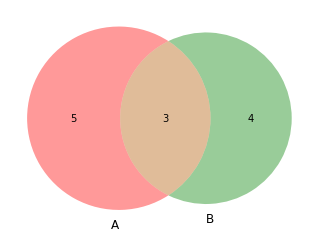

In [243]:
#Venn diagram for two collections
#A has 8 items; B has 7. They have 3 in common.
compare1 = Compare(two_collect)


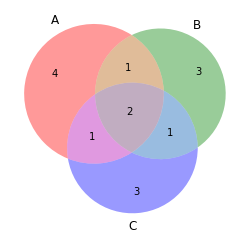

In [244]:
# What happens with three collections
compare2 = Compare(three_collect)


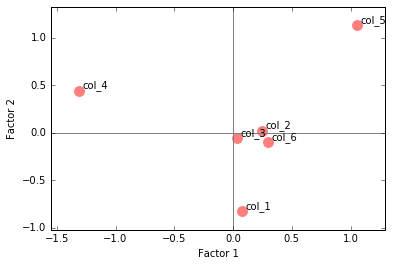

In [245]:
# With more than three collections, the output switches to correspondence analysis.
# Katherine Faust offers a great overview of the method here:
# www.socsci.uci.edu/~kfaust/faust/research/articles/articles.htm
# In this case, collection 2, 3 & 6 have more in common with each other than with the other collections, so
# would be the best possible consideration for a common social network analysis.
# Collection 1 may be another consideration.
compare3 = Compare(all_collect)

In [248]:
# Just to show the table of who matches with whom.
print (compare3.ca)

            col_1  col_2  col_3  col_4  col_5  col_6
amazon       True  False  False  False  False   True
apple        True   True   True   True  False   True
beaver      False  False   True  False  False  False
cow         False   True   True  False  False  False
google       True   True   True  False  False   True
ibm          True  False  False  False  False  False
jive        False  False  False  False   True  False
jump        False  False  False   True  False  False
microsoft    True  False  False  False  False  False
msn          True  False   True  False  False   True
napster      True   True  False   True  False   True
oracle       True  False  False  False  False  False
pear        False   True  False  False   True  False
run         False  False  False   True  False  False
saunter     False  False  False   True  False  False
skunk       False  False   True   True  False  False
tango       False  False  False  False   True   True
thebeatles  False   True  False  False  False 